# Building a spam email classifier
## Practice with: Feature Engineering, Logistic Regression, Cross Validation

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

Using version already downloaded: Fri Apr  5 08:00:24 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Fri Apr  5 08:00:26 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


In [4]:
#fix missing values
original_training_data.isnull().sum()
original_training_data['subject'] = original_training_data['subject'].replace({np.nan:''})
original_training_data.isnull().sum()

id         0
subject    0
email      0
spam       0
dtype: int64

Train / Test Split

In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

In order to build a classifier we have to first build a feature matrix. Since the data we currently have are all text based, we need to divise a way to turn these into numerical (ideally 0/1) data.

We start by building a function which takes list of words and compares it to a pandas Series to determine whether a word  is included in each element of the series. 

e.g.:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.zeros((texts.size,len(words)),dtype=int)
    for i in range(texts.size):
        for word in words:
            if word in texts.iloc[i]:
                indicator_array[i,words.index(word)] = 1
    return indicator_array

We want to identify certain features which differentiate a spam and non-spam email, one simple way is comparing the distribution of instances of words within email bodies, since this is a binary indicator and quite easily compared. This means finding words which have high prevelances, but are disproportionately found in one type of email or the other.

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


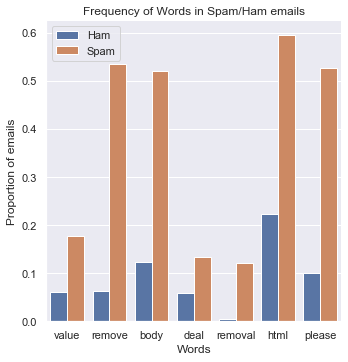

In [9]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
train_copy = train.copy()
words = ['value','remove','body','deal','removal','html','please']
word_array = words_in_texts(words,train.email)
for word in words: 
    train_copy[word] = word_array[:,words.index(word)]
melted_train = train_copy[words+['spam']].melt('spam')
sns.set(rc={'figure.figsize':(8,5.65)})
sns.factorplot(x='variable',y='value',hue='spam',data=melted_train,kind='bar',ci=None,legend=False)
plt.xlabel('Words')
plt.legend(['Ham','Spam'])
plt.title('Frequency of Words in Spam/Ham emails')
plt.ylabel('Proportion of emails')
plt.show();

Additionally we can compare the distribution of the lengths of the two types of emails 

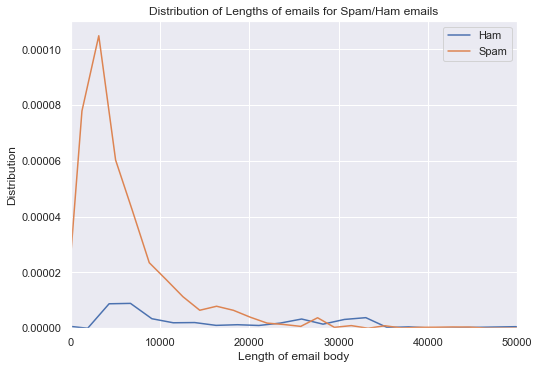

In [10]:
train['length'] = [len(email) for email in train.email.values]
sns.distplot(train[train.spam==0].length,hist=False,label='Ham')
sns.distplot(train[train.spam == 1].length,hist=False,label='Spam')
plt.xlim([0,50000])
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.title('Distribution of Lengths of emails for Spam/Ham emails')
plt.show()

In [11]:
def format_data(data):
    """
    DATA: a dataframe of N rows with (at least) the following columns:
        subject: string representing the subject of the email
        email: string representing the text content of the email
    
    #######
    format_data takes the input dataframe and produces an array of dimensions N x 13 
    where 13 is the total number of observations included in the regression model.
    RETURNS: X_test, an N x 13 array 
    """
    #remove NaN from subject
    data['subject'] = data['subject'].replace({np.nan:''})
    model_words=['<body>', '<html>', 'please', 'offer', '<head>','<table>','remove','valued','removal','unsubscribe']
    #emails below 15,000 char threshold
    short_emails = [1 if len(email)<15000 else 0 for email in data.email.values] 
    # total count of puncuation in each email body
    punc_count = [len(re.findall(r'[!#?.,@]',email)) for email in data.email.values]
    # total count of email addresses in email body (code borrowed from emailregex.com)
    address_count = [len(re.findall(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)",email)) for email in data.email.values]
    # is a reply
    reply = [1 if 'Re:' in subject else 0 for subject in data.subject.values]
    
    X_train = words_in_texts(model_words,data.email)
    X_train = np.c_[X_train,short_emails,punc_count,address_count,reply]
    return X_train

In [18]:
X_train = format_data(train)
Y_train = train.spam

In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train,Y_train)
prediction = model.predict(X_train)
training_accuracy = np.mean([1 if prediction[x] == Y_train[x] else 0 for x in range(len(prediction))])
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9005723412751231


C:\Users\alexc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
